<a href="https://colab.research.google.com/github/wanderingxplorer1/ml-projects/blob/main/amazon-book-reviews/AmazonBookReviewsSimpleModLr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Book Reviews
Predicting the review rating of a book using reviews/ratings to train a DNN.
The dataset can be found in https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

In [ ]:
import os
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Embedding, Flatten, IntegerLookup, Dropout
from tensorflow.keras import Model
from tensorflow.keras import Input
import matplotlib.pyplot as plt

# Download the data
We will be using the Amazon book reviews dataset to create a model to predict
the rating of a book given it's review.

The dataset can be found in https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! mkdir ~/.kaggle
! cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d mohamedbakhet/amazon-books-reviews

100% 1.06G/1.06G [00:29<00:00, 45.5MB/s]
100% 1.06G/1.06G [00:29<00:00, 39.0MB/s]


In [ ]:
! unzip amazon-books-reviews.zip
book_ratings_csv = "/content/Books_rating.csv"

Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


# Prepare the dataset
The dataset is very unbalanced. Most of the ratings are 4 or 5 stars.
In order to balance it, we will create 5 datasets, one for each review rating
and then combine them. We will sample each dataset with equal probablity
to create the final dataset.

Also, the ratings are floats from 1.0 5.0. We will map them to integers from
0-4 so that we can use them as labels for a sparse_categorical_crossentropy loss
so that we don't to one-hot encode them.

In [ ]:
BATCH_SIZE = 32
TRAIN_SIZE = 128000
VAL_SIZE = 12800
TEST_SIZE = 12800

dataset = tf.data.experimental.make_csv_dataset(book_ratings_csv,
                                                batch_size=BATCH_SIZE,
                                                select_columns=["review/summary", "review/score"],
                                                label_name="review/score")
dataset1 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 1.0))
dataset2 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 2.0))
dataset3 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 3.0))
dataset4 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 4.0))
dataset5 = dataset.unbatch().filter(lambda x, y : tf.equal(y, 5.0))

books_dataset = tf.data.Dataset.sample_from_datasets(
    [dataset1, dataset2, dataset3, dataset4, dataset5], stop_on_empty_dataset=True)

# Extract out the review from the OrderedDict.
# Change labels from 1.0-5.0 to 0-4 so that we can use them as labels without
# have to one-hot encode them.
books_dataset = books_dataset.map(lambda x, y : (x['review/summary'], int(y)-1))
train_ds = books_dataset.take(TRAIN_SIZE).batch(BATCH_SIZE)
val_ds = books_dataset.take(VAL_SIZE).batch(BATCH_SIZE)
test_ds = books_dataset.take(TEST_SIZE).batch(BATCH_SIZE)

for batch in test_ds.take(1):
  print(batch)

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Nice collection of Julie Strain images', b'This is a classic?',
       b'Tired Sci Fi Cliche',
       b'&quot;Hallelujah!&quot; is what I said when I finished this book',
       b'Why is kindle version so expensive???!',
       b'Not very much depth or substance to this one',
       b'Packed with info', b'so boring.....', b'Better than the first!',
       b'Gold1 Gold1 and more Gold!', b'Very interesting, but sad.',
       b'How a religion is Born!', b'Penguin clothbound classics',
       b"Asimov's early work his best",
       b'Anyone but Hauptmann - Red Herrings That Never Die',
       b'worst book in the world!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
       b'Get foundation first', b'Great introduction to Jewish practices',
       b'Lifetimes: Not ONLY about death', b'Another Koontz sucess',
       b'thoroughly researched and readable', b'Self-Serving Message',
       b'Long and boring', b'Do I have to give it a star?', b'Foundat

In [ ]:
vectorize_ds = train_ds.map(lambda x, y: x)
MAXLEN = 100
NUM_WORDS = 5000
EMBEDDING_DIM = 7
vectorize_layer = tf.keras.layers.TextVectorization(
  max_tokens=NUM_WORDS,
  output_mode='int',
  output_sequence_length=MAXLEN)
vectorize_layer.adapt(vectorize_ds)

In [ ]:
vectorize_layer('Characters that are shallower than my kitchen sink')

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([ 165,   46,   66,    1,   65,   31, 3150, 3813,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])>

In [ ]:
input = Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(input)
x = Embedding(vectorize_layer.vocabulary_size(), EMBEDDING_DIM, input_length=MAXLEN)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dense(5, activation='softmax')(x)

classifier = Model(input, x)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
classifier.compile(loss='sparse_categorical_crossentropy',
                   optimizer=adam,
                   metrics=['sparse_categorical_accuracy'])
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 7)            35000     
                                                                 
 flatten (Flatten)           (None, 700)               0         
                                                                 
 dense (Dense)               (None, 64)                44864     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                             

In [ ]:
input_text = tf.constant(["A FAST PACED , FIRST RATE MUST READ STORY!!!"])
classifier.predict(input_text)

1/1 [==============================] - 1s 640ms/step


array([[0.1941649 , 0.20910424, 0.19661106, 0.19958235, 0.20053746]],
      dtype=float32)

In [ ]:
classifier.evaluate(test_ds)

400/400 [==============================] - 9s 19ms/step - loss: 1.6097 - sparse_categorical_accuracy: 0.1980


[1.6097402572631836, 0.1979687511920929]

In [ ]:
history = classifier.fit(train_ds, validation_data=[val_ds], epochs=40)

Epoch 1/40
4000/4000 [==============================] - 112s 27ms/step - loss: 1.2999 - sparse_categorical_accuracy: 0.4302 - val_loss: 1.2962 - val_sparse_categorical_accuracy: 0.4487
Epoch 2/40
4000/4000 [==============================] - 92s 23ms/step - loss: 1.2026 - sparse_categorical_accuracy: 0.4851 - val_loss: 1.2649 - val_sparse_categorical_accuracy: 0.4641
Epoch 3/40
4000/4000 [==============================] - 98s 24ms/step - loss: 1.1668 - sparse_categorical_accuracy: 0.5028 - val_loss: 1.2325 - val_sparse_categorical_accuracy: 0.4823
Epoch 4/40
4000/4000 [==============================] - 91s 22ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.5167 - val_loss: 1.1993 - val_sparse_categorical_accuracy: 0.4941
Epoch 5/40
4000/4000 [==============================] - 86s 21ms/step - loss: 1.1167 - sparse_categorical_accuracy: 0.5268 - val_loss: 1.1758 - val_sparse_categorical_accuracy: 0.5052
Epoch 6/40
4000/4000 [==============================] - 104s 26ms/step - loss: 

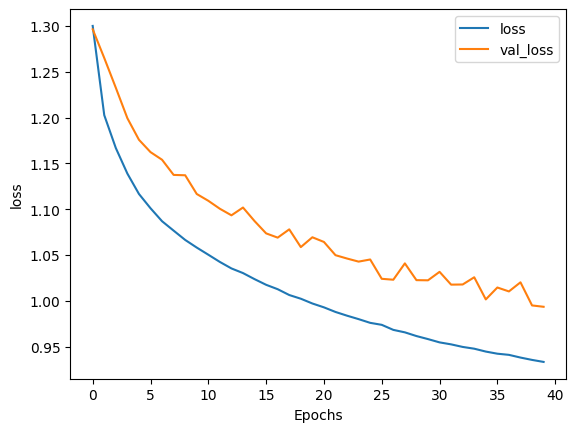

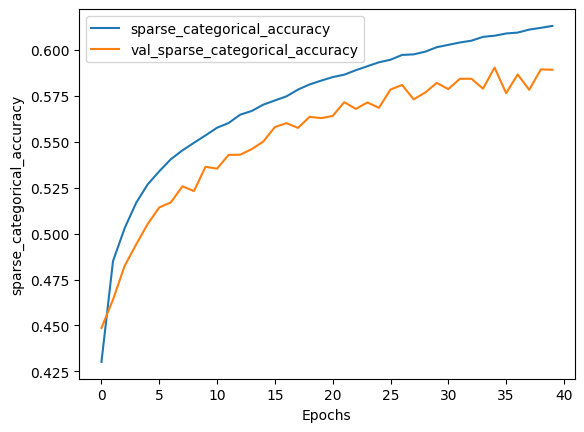

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "loss")
plot_graphs(history, "sparse_categorical_accuracy")

In [ ]:
classifier.predict(["A FAST PACED , FIRST RATE MUST READ STORY!!!"])

1/1 [==============================] - 0s 77ms/step


array([[1.3618202e-04, 3.6028908e-03, 3.1957824e-03, 2.9381609e-01,
        6.9924909e-01]], dtype=float32)

In [ ]:
classifier.evaluate(test_ds)

400/400 [==============================] - 9s 21ms/step - loss: 0.9973 - sparse_categorical_accuracy: 0.5876


[0.9972822666168213, 0.5875781178474426]

In [ ]:
classifier.save('amazon_book_reviews_simple.keras')

In [ ]:
amazon_model = tf.keras.models.load_model('amazon_book_reviews_simple.keras')


In [ ]:
amazon_model.predict(["A FAST PACED , FIRST RATE MUST READ STORY!!!"])

1/1 [==============================] - 0s 115ms/step


array([[1.3618202e-04, 3.6028908e-03, 3.1957824e-03, 2.9381609e-01,
        6.9924909e-01]], dtype=float32)